## Table of Contents

* [Part 1 Data Analysis and Simple Model](#Part-1-Data-Analysis-and-Simple-Model)
* [Part 2 Web Scraping and Simple n grams](#Part-2-Web-Scraping-and-Simple-n-grams) 
* [Part 3 Memoizer](#Part-3-Memoizer) 

### Part 1 Data Analysis and Simple Model 

---

> **1. Methodology**

For predicting *ClosePrice* given the housing data attributes here are the steps I followed:
1. Exploratory Data Analysis
    - Generated initial statistics like: count, mean, standard deviation
    - Removed rows where "ClosePrice" values were missing
    - Removed *outliers* from "LivingArea" feature
    - Removed *outliers* from "ListPrice" feature
2. Feature Engineering
    - Created new feature "NumDays" = "CloseDate" - "ListDate"
    - Created *Dummy Variables* for features: "Pool", "ListingStatus", and "DwellingType"
    - Kept (categories - 1) *Dummy Variables* by removing a few - To take care of *Multicollinearity* problem
    
3. Linear Regression (multi-variable) with ListPrice
    - Train-Test split: 70% train and 30% test
4. Linear Regression (multi-variable) without ListPrice
    - Train-Test split: 70% train and 30% test
5. Calculated *term frequency–inverse document frequency* matrix
    - tf-idf was computed in Feature Engineering step, however tf-idf was not included in modeling because of storage issues on my Macbook Air


I chose multivariable linear regression model because it is simple and easy to interpret.


---

> **2. Excluding "ListPrice"**

**Linear model with "ListPrice" performs much better** than linear model without "ListPrice". For the linear model with "ListPrice", I used *t-test* to test the significance the coefficient of "ListPrice" and found that it is significant (p-value = 0.0, which is less than alpha = 0.05). Model performance results can be seen in the next section.

---

> **3. Model Performance and Error Metrics**

I used 4 error matrices: Mean Squared Error (MSE), Root Mean squared Error (RMSE), $R^2$, and $\bar{R^2}$. Please check the table belo:

|Metrics   	|Model with ListPrice   	|Model without ListPrice   	| 
|:-:	|:-:	|:-:	|
|   MSE	|   98653745.6145	|   7324505212.41	|   	
|   RMSE	|   9932.45919269 	|   85583.3232144	|  
|   $R^2$	|   0.994663069103	|   0.603761844691	|  
|    $\bar{R}^2$*       |    0.999   |    0.894   |    


Linear model with ListPrice predicts almost perfectly ($\bar{R}^2$ = 0.999), however there is a possibility of overfitting and even after removing outliers (conservatively), there are still lot of outliers remaining. Please check the plots for LivingArea and ListPrice (right tailed histograms)

Note: * $\bar{R}^2$ was calculated without intercept

---

> **4. Model Improvement** 

The model can be improved by:

    - Removing outliers
    - Transforming independent variables when their relationship with dependent variable is non-linear
    - Perform a k-fold crossvalidation
    - Regression with regularization (Lasso, Ridge) to solve overfitting

---

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!ls

Simple_Housing_Model.ipynb        data_sci_snippet.csv
TakeHomeProblem-DataScientist.pdf test.csv


In [3]:
# Read data
df = pd.read_csv('data_sci_snippet.csv', parse_dates = [6, 11])
df.head(3)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,PublicRemarks,CloseDate,ClosePrice,ListingStatus,DwellingType
0,5077399,3054,4,2.5,Private,1,2014-03-04,675000,33.593239,-111.961056,This property OUTSTANDING offers outdoor livin...,NaT,NaN,Cancelled,Single Family - Detached
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,Very special home in popular Arabian Views fee...,2014-06-24,460000,Closed,Single Family - Detached
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,Welcome home to a beautiful remodeled. Single ...,2014-07-15,279900,Closed,Single Family - Detached


In [4]:
print df.columns.values

['ListingId' 'LivingArea' 'NumBedrooms' 'NumBaths' 'Pool' 'ExteriorStories'
 'ListDate' 'ListPrice' 'GeoLat' 'GeoLon' 'PublicRemarks' 'CloseDate'
 'ClosePrice' 'ListingStatus' 'DwellingType']


#### Some features to consider while predicting ClosePrice:
- Number of days between ListDate and CloseDate
- Proximity to Schools
- Proximity to Grocery Stores/Shops/Entertainment areas
- Proximity to freeway/major arterials
- Proximity to Employment centers
- Crime rate in the area
- Pollution levels
- Age of the unit

In [5]:
print '# of Rows: {} and # of Columns: {}'.format(df.shape[0], df.shape[1])
print '# of unique Listing Ids: ', len(df['ListingId'].unique())

# of Rows: 57258 and # of Columns: 15
# of unique Listing Ids:  57258


## EDA

In [6]:
# Simple Statistics
df.describe()
# Note: Data is from Phoenix (As per mean GeoLat and mean GeoLon) http://www.darrinward.com/lat-long/

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice
count,57258.000000,57049.000000,57258.000000,57258.000000,57258.000000,57258.000000,57159.000000,57159.000000,37934.000000
mean,5120967.533777,2239.875998,3.291802,2.386840,1.374480,289744.089280,33.509309,-111.985059,240640.726314
std,25448.785984,41870.559466,0.974414,5.175299,0.863922,349387.183416,0.311303,0.383118,197364.706939
min,5077399.000000,0.000000,0.000000,0.000000,1.000000,750.000000,30.214099,-151.064452,1.000000
25%,5098855.250000,1427.000000,3.000000,2.000000,1.000000,149900.000000,33.364152,-112.195982,140000.000000
50%,5120463.500000,1837.000000,3.000000,2.000000,1.000000,215000.000000,33.489423,-111.993189,195000.000000
75%,5143011.750000,2446.000000,4.000000,2.500000,2.000000,325000.000000,33.623773,-111.794199,280475.000000
max,5178286.000000,9999999.000000,16.000000,1047.000000,23.000000,16950000.000000,60.477336,-95.456786,5500000.000000


- Need to predict ClosePrice
- Out of 57258 possible values ClosePrice is missing 19324 values. Drop these rows

In [7]:
df = df[np.isfinite(df['ClosePrice'])]

In [8]:
df.describe()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice
count,37934.000000,37838.000000,37934.000000,37934.000000,37934.000000,37934.000000,37909.000000,37909.000000,37934.000000
mean,5120492.315337,2201.140903,3.241393,2.294432,1.335952,247899.142484,33.491944,-112.000680,240640.726314
std,25414.311792,51405.117468,0.915405,5.718883,0.803313,212186.180691,0.245669,0.293103,197364.706939
min,5077408.000000,0.000000,0.000000,0.000000,1.000000,8500.000000,31.444146,-114.680805,1.000000
25%,5098393.500000,1400.000000,3.000000,2.000000,1.000000,144897.000000,33.363611,-112.205246,140000.000000
50%,5119879.000000,1761.000000,3.000000,2.000000,1.000000,199900.000000,33.481969,-112.007252,195000.000000
75%,5142494.750000,2277.750000,4.000000,2.500000,2.000000,289500.000000,33.617180,-111.805394,280475.000000
max,5178286.000000,9999999.000000,16.000000,1047.000000,23.000000,7400000.000000,36.775648,-109.092285,5500000.000000


In [9]:
print df.columns.values

['ListingId' 'LivingArea' 'NumBedrooms' 'NumBaths' 'Pool' 'ExteriorStories'
 'ListDate' 'ListPrice' 'GeoLat' 'GeoLon' 'PublicRemarks' 'CloseDate'
 'ClosePrice' 'ListingStatus' 'DwellingType']


In [10]:
print 'Number of Bedrooms: ', list(np.sort(df['NumBedrooms'].unique()))

Number of Bedrooms:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 16]


In [11]:
print 'Number of Baths: ', list(np.sort(df['NumBaths'].unique()))
# Outliers: 134 and greater. 1047 is too extreme!

Number of Baths:  [0.0, 0.070000000000000007, 0.75, 1.0, 1.25, 1.3400000000000001, 1.5, 1.5700000000000001, 1.7, 1.72, 1.75, 2.0, 2.1000000000000001, 2.25, 2.3300000000000001, 2.5, 2.5299999999999998, 2.6499999999999999, 2.6699999999999999, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 10.0, 11.0, 22.0, 25.0, 134.0, 175.0, 205.0, 212.0, 1047.0]


In [12]:
print 'Pool Type: ', list(np.sort(df['Pool'].unique()))

Pool Type:  ['Both Private & Community', 'Community', 'None', 'Private']


In [13]:
print 'Exterior Stories: ', list(np.sort(df['ExteriorStories'].unique()))

Exterior Stories:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 20.0, 21.0, 22.0, 23.0]


In [14]:
print 'Listing Status: ', list(np.sort(df['ListingStatus'].unique()))

Listing Status:  ['Active', 'Cancelled', 'Closed', 'Expired', 'Pending', 'Temp Off Market']


In [15]:
print 'Dwelling Type: ', list(np.sort(df['DwellingType'].unique()))

Dwelling Type:  ['Apartment Style/Flat', 'Gemini/Twin Home', 'Loft Style', 'Mfg/Mobile Housing', 'Modular/Pre-Fab', 'Patio Home', 'Single Family - Detached', 'Townhouse']


In [16]:
# Get count of dwelling type
dwelling_types = list(np.sort(df['DwellingType'].unique()))
for dwelling_type in dwelling_types:
    temp_df = df[df['DwellingType'] == dwelling_type]
    print dwelling_type + ' count: ' + str(temp_df.shape[0])

Apartment Style/Flat count: 1796
Gemini/Twin Home count: 258
Loft Style count: 30
Mfg/Mobile Housing count: 731
Modular/Pre-Fab count: 17
Patio Home count: 503
Single Family - Detached count: 31999
Townhouse count: 2600


In [17]:
# Get mean area and mean list price by dwelling type
dwelling_types = list(np.sort(df['DwellingType'].unique()))
for dwelling_type in dwelling_types:
    temp_df = df[df['DwellingType'] == dwelling_type]
    print dwelling_type + ' average living area: ' + str(temp_df['LivingArea'].mean()) \
    + ' and average list price: ' + str(temp_df['ListPrice'].mean())

Apartment Style/Flat average living area: 1071.0424581 and average list price: 149218.801225
Gemini/Twin Home average living area: 1424.77906977 and average list price: 125866.069767
Loft Style average living area: 1191.5 and average list price: 291860.0
Mfg/Mobile Housing average living area: 1336.45530726 and average list price: 95424.506156
Modular/Pre-Fab average living area: 589547.705882 and average list price: 524311.470588
Patio Home average living area: 1466.83665339 and average list price: 218495.427435
Single Family - Detached average living area: 2058.25324126 and average list price: 264916.199162
Townhouse average living area: 1360.03008099 and average list price: 164982.535385


In [18]:
# Living Area outliers
temp = df['LivingArea']
living_area = np.sort(temp.unique())
print 'Area lows: ', list(living_area[:20])
print 'Area highs: ', list(living_area[len(living_area)-10:])

Area lows:  [0.0, 1.0, 160.0, 168.0, 246.0, 288.0, 386.0, 390.0, 394.0, 395.0, 396.0, 399.0, 400.0, 402.0, 404.0, 409.0, 413.0, 420.0, 429.0, 442.0]
Area highs:  [8735.0, 8822.0, 8861.0, 9320.0, 10059.0, 10322.0, 13055.0, 16267.0, 9999999.0, nan]


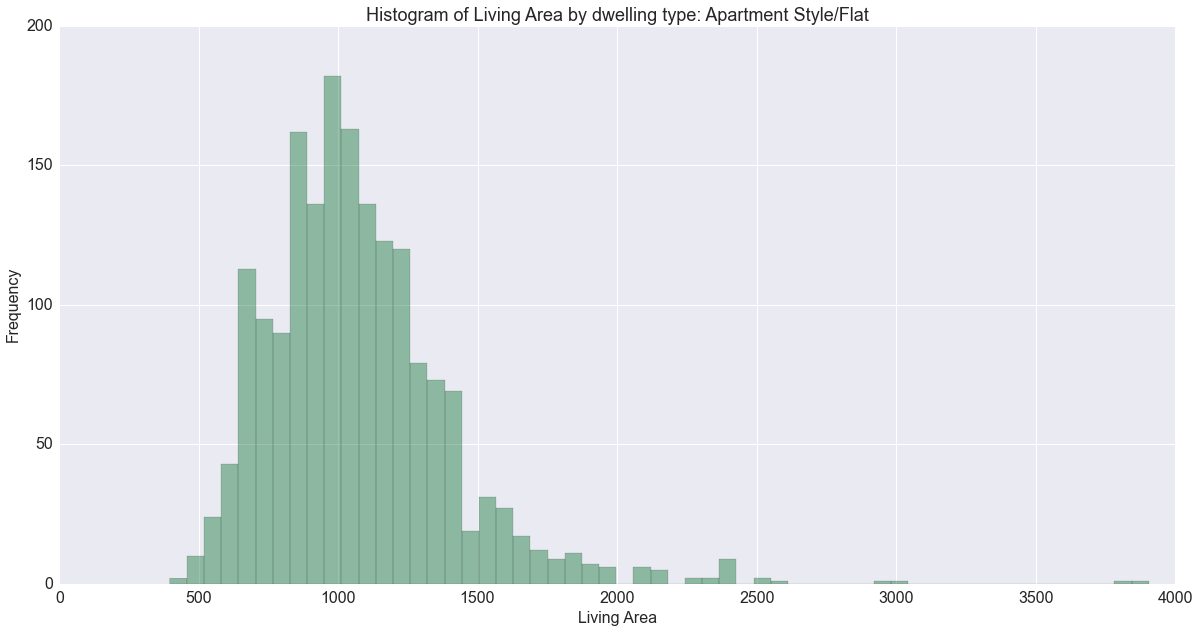

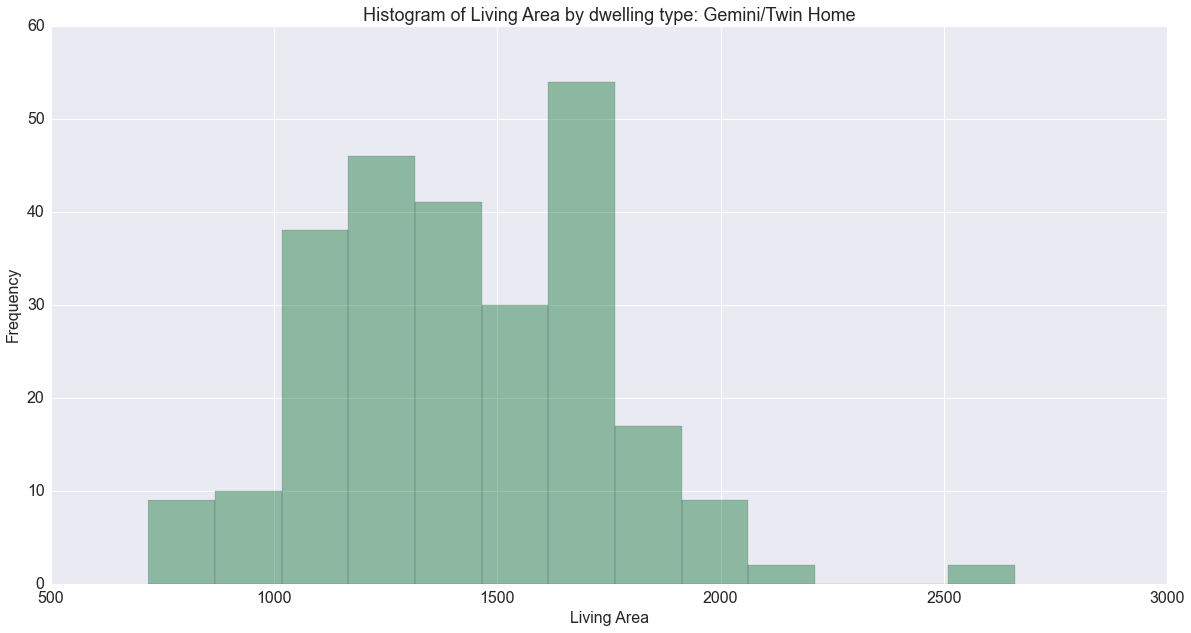

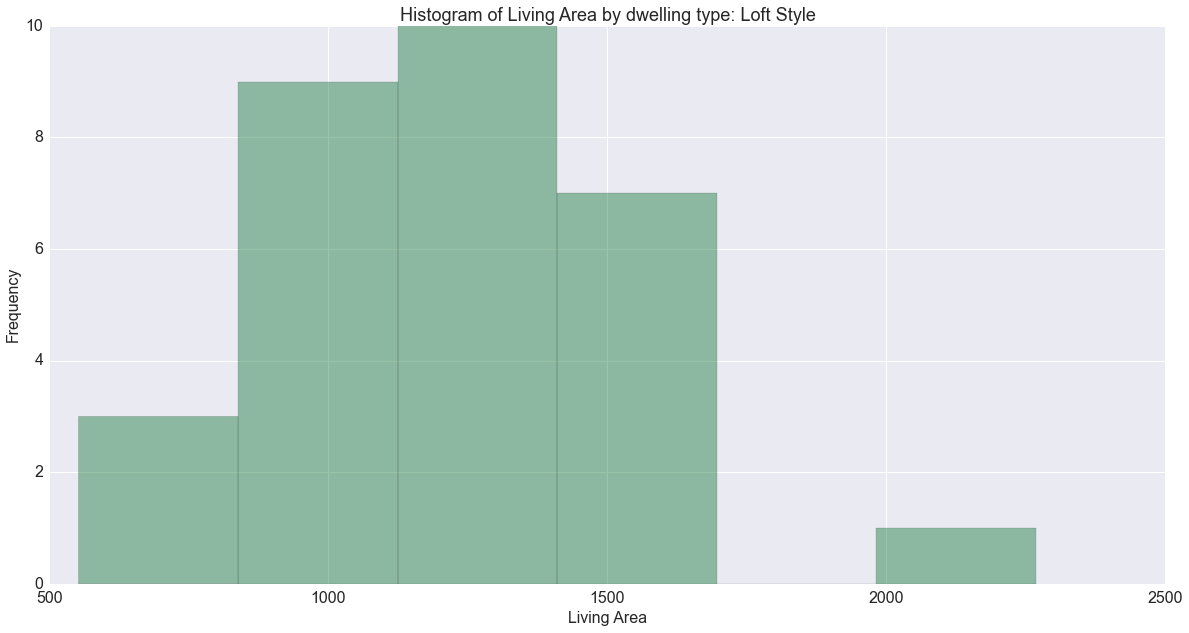

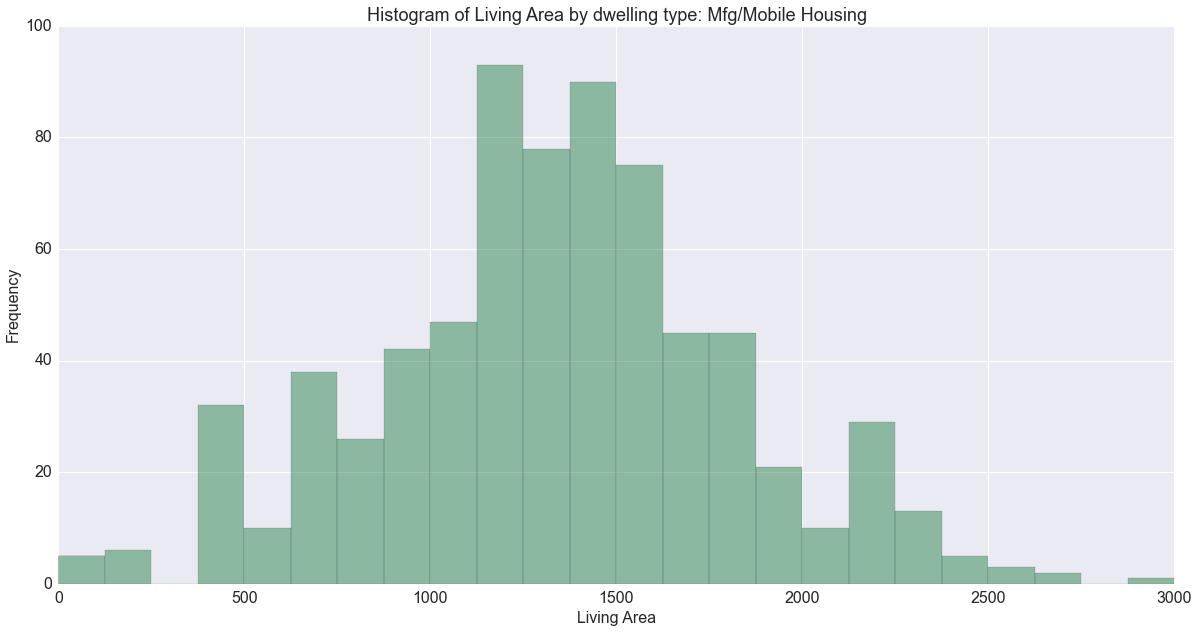

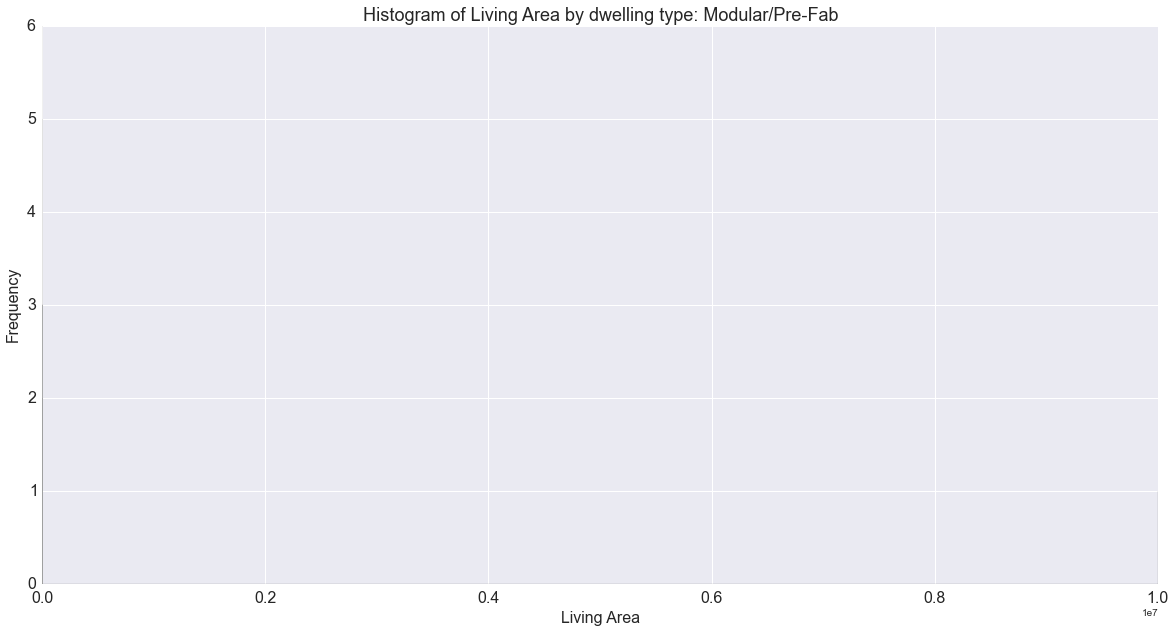

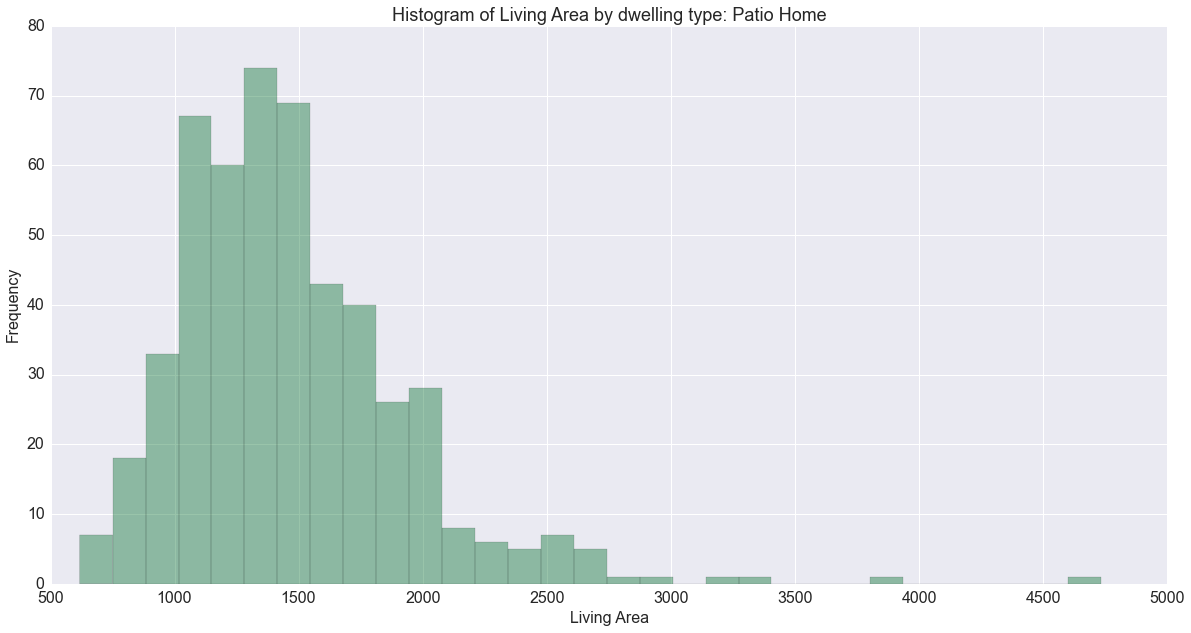

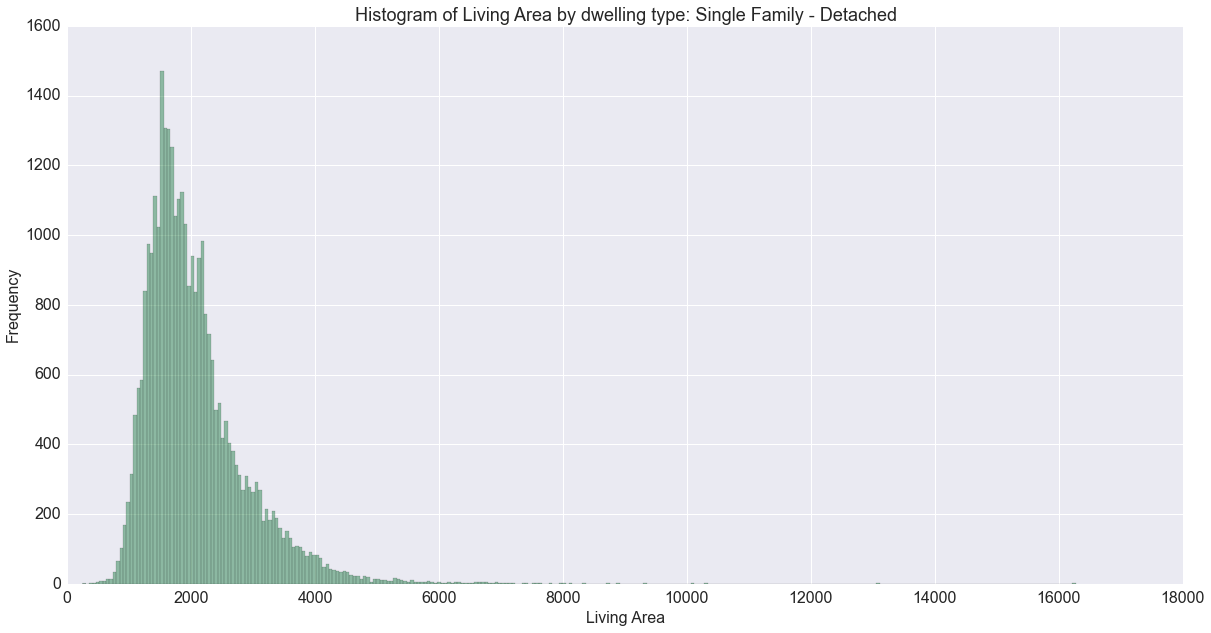

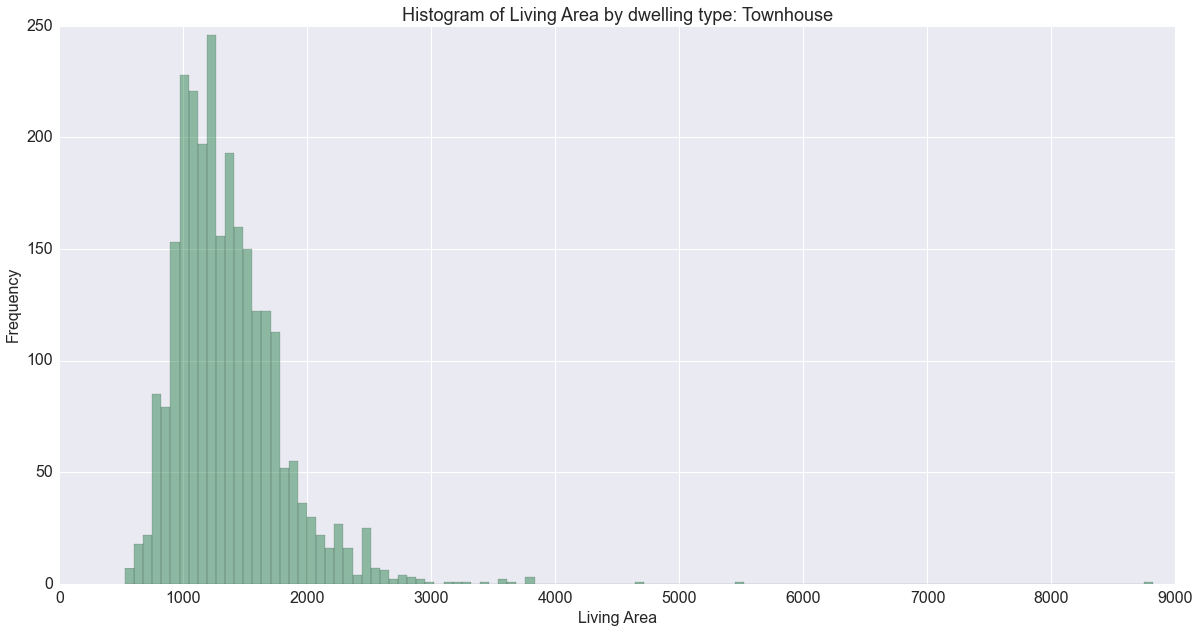

In [19]:
# Check Living Area by dwelling type
for dwelling_type in dwelling_types:
    temp_df = df[df['DwellingType'] == dwelling_type]
    plt.figure(figsize = (20, 10))
    sns.distplot(temp_df['LivingArea'].dropna(), kde = False, rug = False, color =  '#006d2c')
    plt.xlabel('Living Area', fontsize = 16)
    plt.ylabel('Frequency', fontsize = 16)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
    plt.title('Histogram of Living Area by dwelling type: ' + dwelling_type, fontsize = 18)

In [20]:
for dwelling_type in dwelling_types:
    temp_df = df[df['DwellingType'] == dwelling_type]['LivingArea']
    min_val = temp_df.min()
    max_val = temp_df.max()
    print 'Dwelling type: ' + dwelling_type + ' min living area: {} and max living area: {}'.format(min_val, max_val)

Dwelling type: Apartment Style/Flat min living area: 395.0 and max living area: 3904.0
Dwelling type: Gemini/Twin Home min living area: 718.0 and max living area: 2660.0
Dwelling type: Loft Style min living area: 552.0 and max living area: 2268.0
Dwelling type: Mfg/Mobile Housing min living area: 0.0 and max living area: 3000.0
Dwelling type: Modular/Pre-Fab min living area: 400.0 and max living area: 9999999.0
Dwelling type: Patio Home min living area: 616.0 and max living area: 4734.0
Dwelling type: Single Family - Detached min living area: 246.0 and max living area: 16267.0
Dwelling type: Townhouse min living area: 528.0 and max living area: 8822.0


In [21]:
df[(df['LivingArea'] >= 395) & (df['LivingArea'] <= 6000)].describe()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice
count,37733.000000,37733.000000,37733.000000,37733.000000,37733.000000,37733.000000,37710.000000,37710.000000,37733.000000
mean,5120531.825193,1925.563075,3.237087,2.286685,1.335966,243810.415048,33.490798,-112.001345,237099.365277
std,25426.452672,772.797277,0.904379,5.729965,0.804451,182396.671798,0.242886,0.291206,173997.063054
min,5077408.000000,395.000000,0.000000,0.000000,1.000000,8500.000000,31.444146,-114.680805,1.000000
25%,5098407.000000,1400.000000,3.000000,2.000000,1.000000,144900.000000,33.363319,-112.205675,140000.000000
50%,5119928.000000,1759.000000,3.000000,2.000000,1.000000,199900.000000,33.481665,-112.007857,195000.000000
75%,5142585.000000,2271.000000,4.000000,2.500000,2.000000,289000.000000,33.616921,-111.805645,280000.000000
max,5178286.000000,6000.000000,8.000000,1047.000000,23.000000,4300000.000000,36.775648,-109.092285,4160000.000000


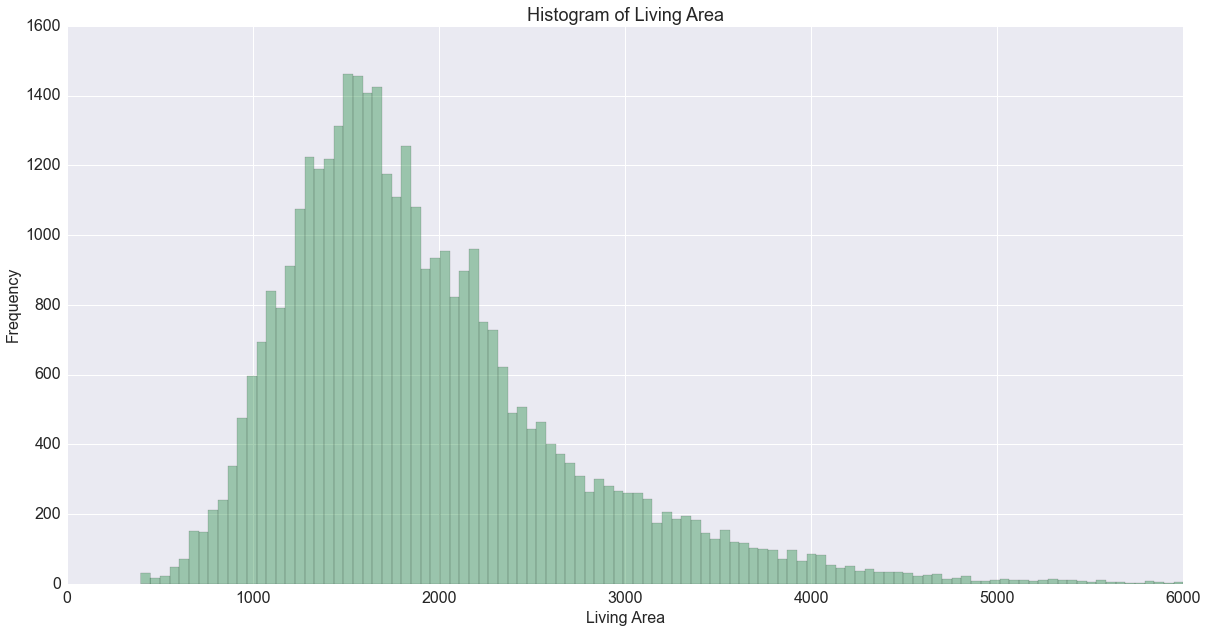

In [22]:
temp_df = df[(df['LivingArea'] >= 395) & (df['LivingArea'] <= 6000)]
plt.figure(figsize = (20, 10))
sns.distplot(temp_df['LivingArea'].dropna(), kde = False, rug = False, color =  '#238b45')
plt.xlabel('Living Area', fontsize = 16)
#plt.xscale('log')
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram of Living Area', fontsize = 18)

**Note:** 
- Living Area Outliers: <font color=red>Need to remove datapoints where LivingArea is less than 395 and LivingArea is greater than 6000. </font> **Right tailed distribution**

In [23]:
# Remove LivingArea outliers
df = df[(df['LivingArea'] >= 395) & (df['LivingArea'] <= 6000)]

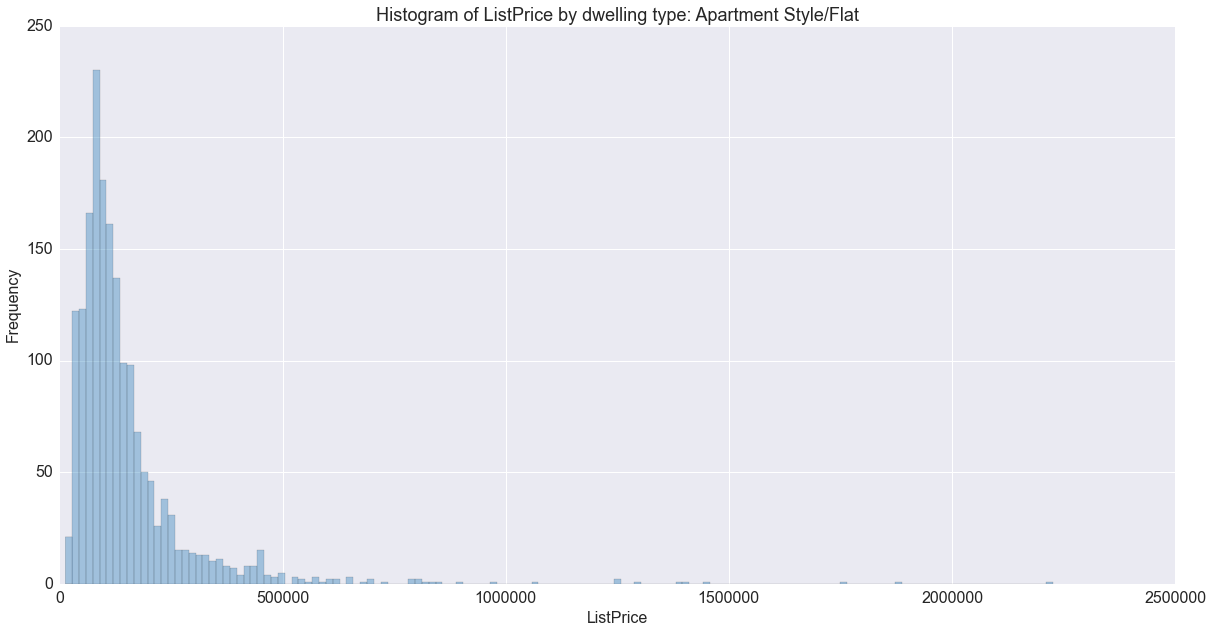

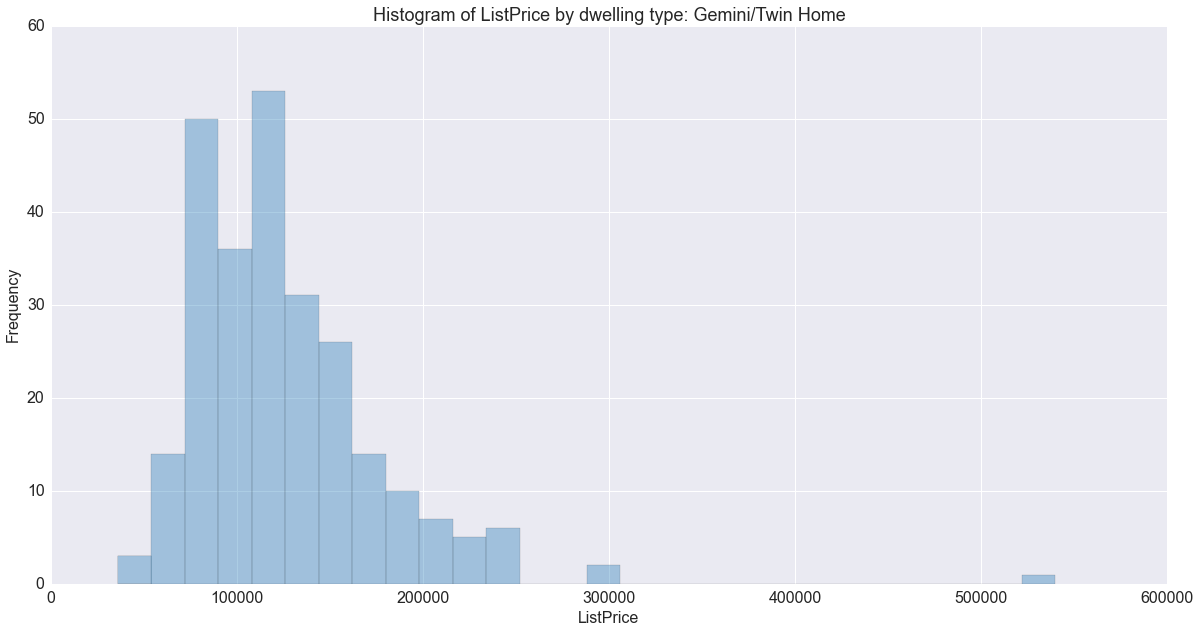

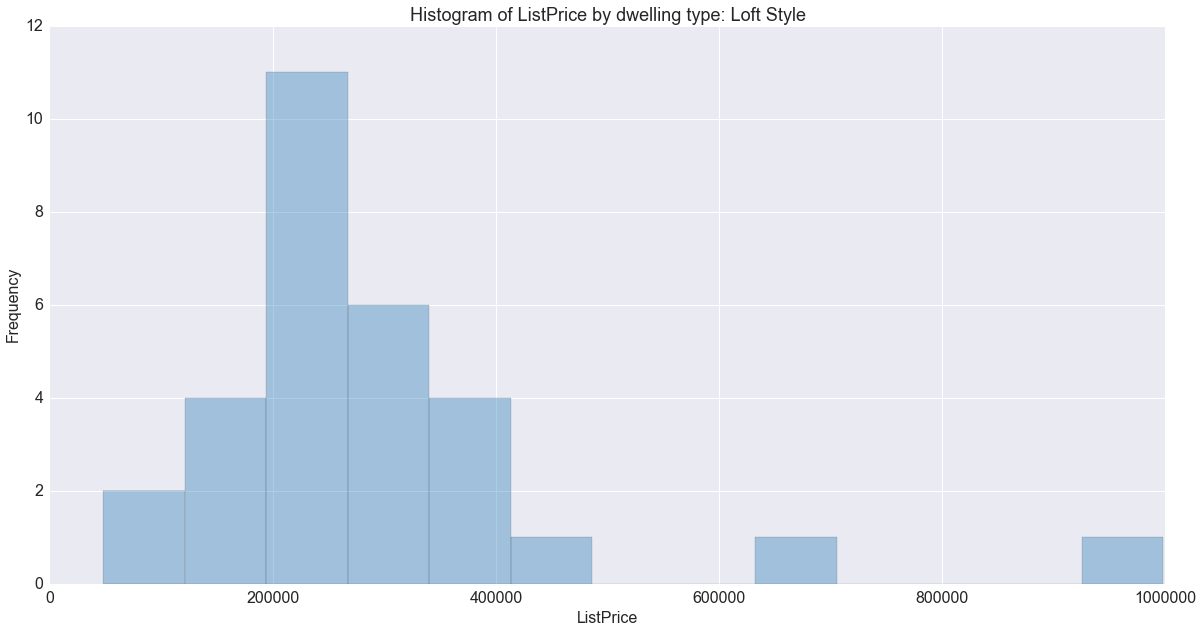

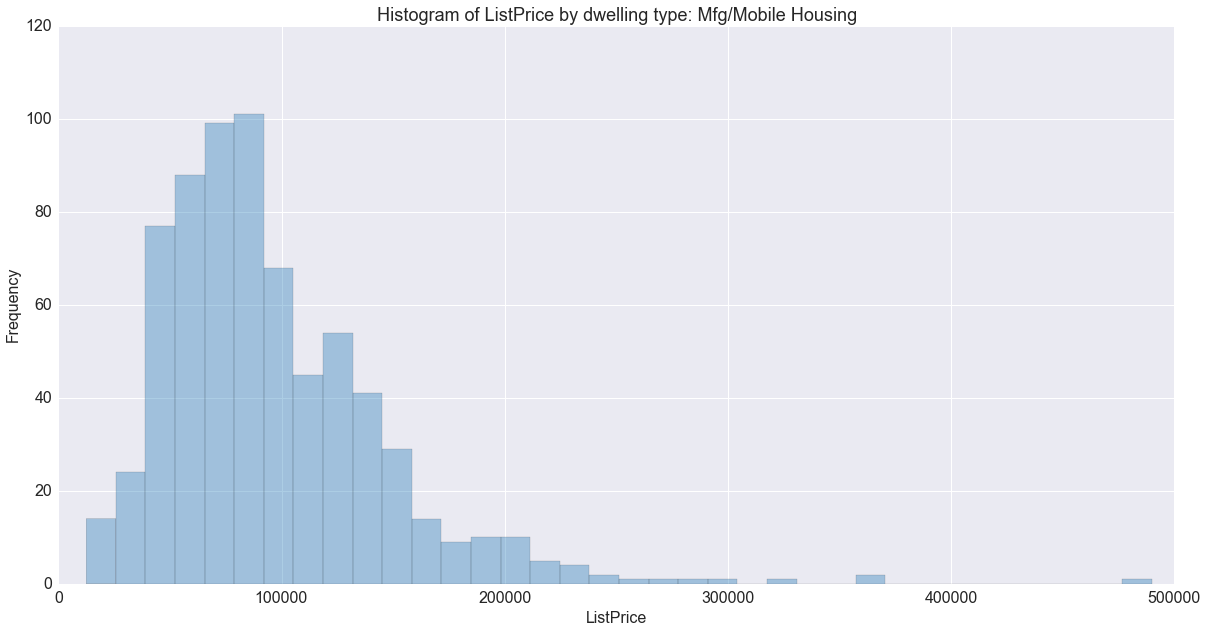

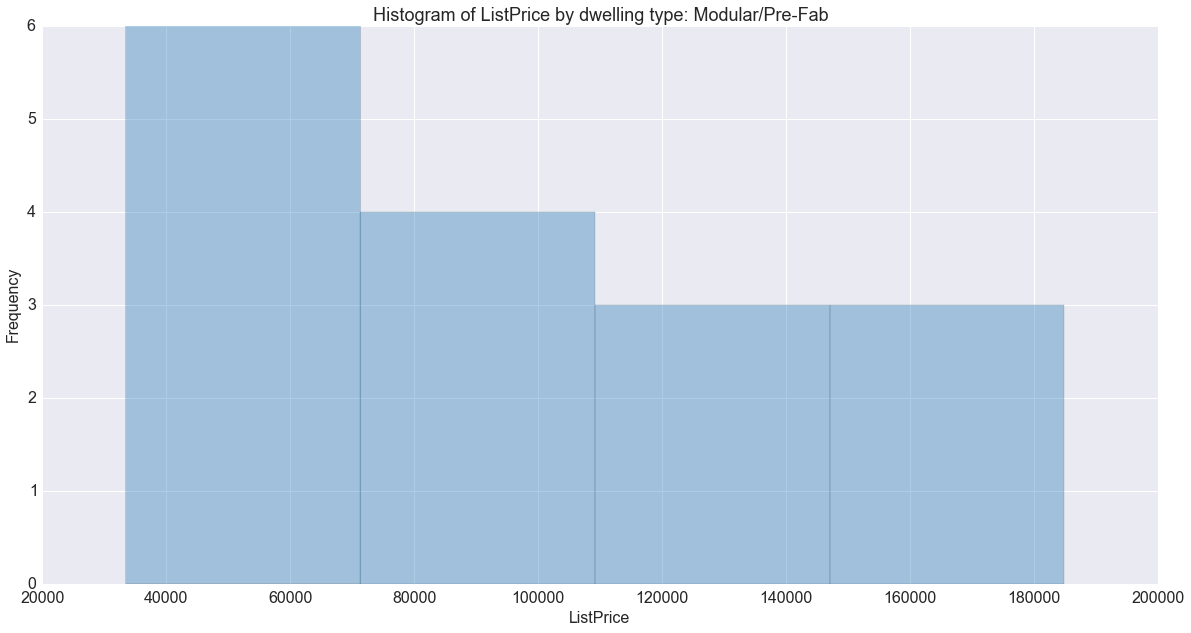

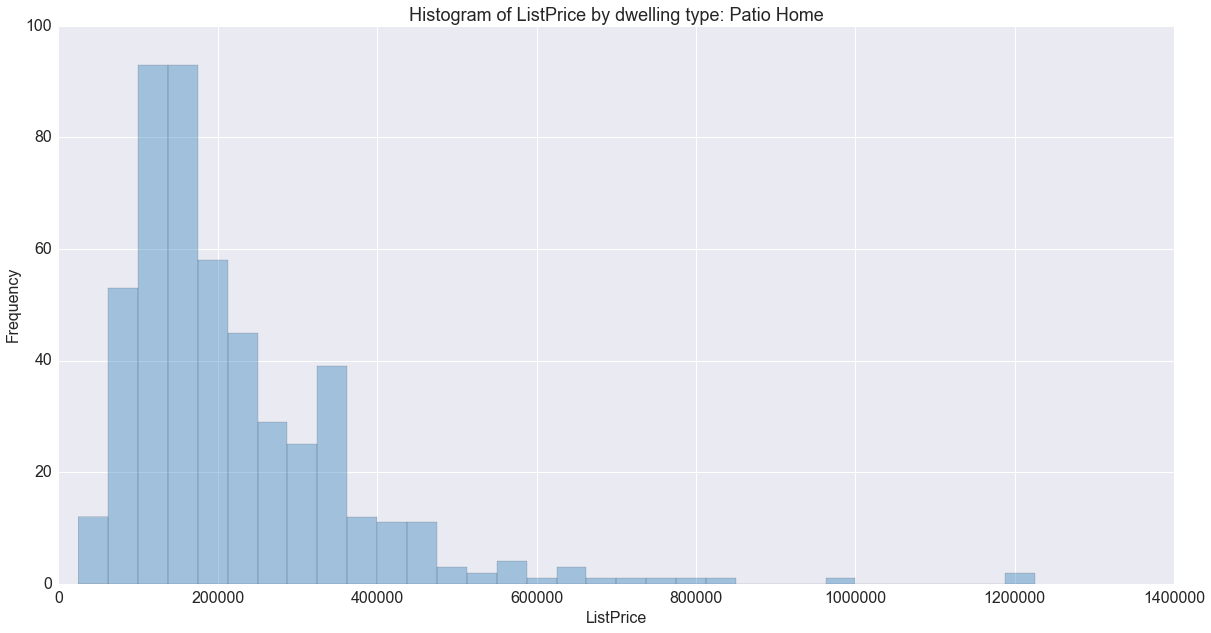

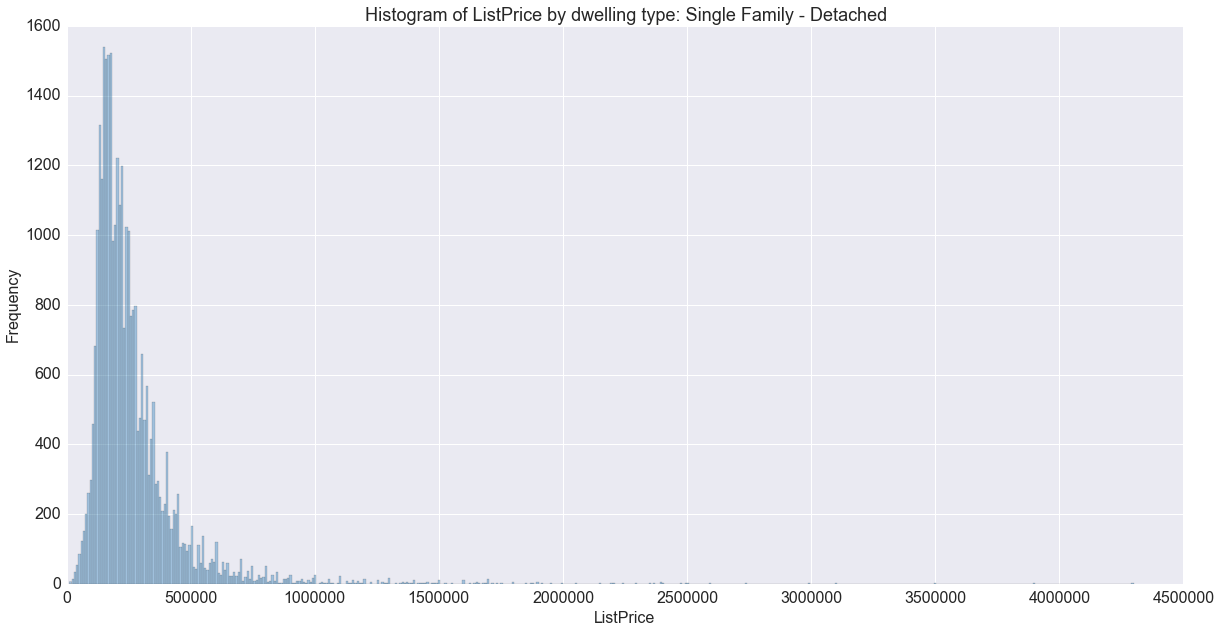

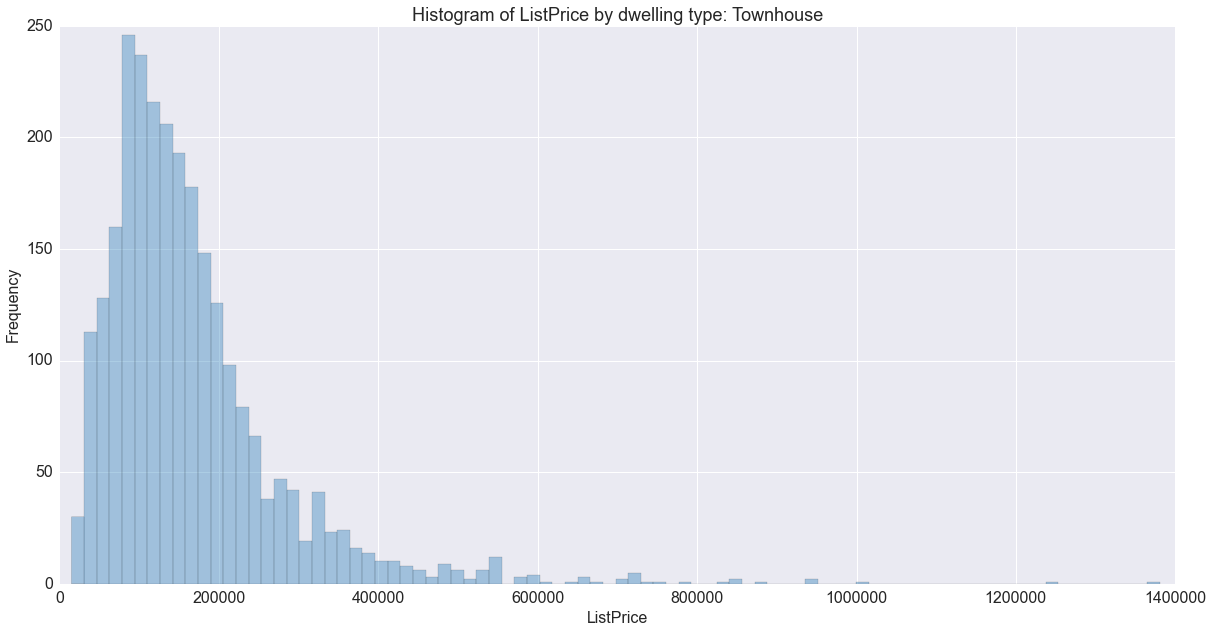

In [24]:
# Check ListPrice by dwelling type
for dwelling_type in dwelling_types:
    temp_df = df[df['DwellingType'] == dwelling_type]
    plt.figure(figsize = (20, 10))
    sns.distplot(temp_df['ListPrice'].dropna(), kde = False, rug = False, color =  '#3182bd')
    plt.xlabel('ListPrice', fontsize = 16)
    plt.ylabel('Frequency', fontsize = 16)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
    plt.title('Histogram of ListPrice by dwelling type: ' + dwelling_type, fontsize = 18)

In [25]:
for dwelling_type in dwelling_types:
    temp_df = df[df['DwellingType'] == dwelling_type]['ListPrice']
    min_val = temp_df.min()
    max_val = temp_df.max()
    print 'Dwelling type: ' + dwelling_type + ', min list price: {} and max list price: {}'.format(min_val, max_val)

Dwelling type: Apartment Style/Flat, min list price: 13000.0 and max list price: 2225000.0
Dwelling type: Gemini/Twin Home, min list price: 36000.0 and max list price: 540000.0
Dwelling type: Loft Style, min list price: 48000.0 and max list price: 998000.0
Dwelling type: Mfg/Mobile Housing, min list price: 12500.0 and max list price: 489900.0
Dwelling type: Modular/Pre-Fab, min list price: 33500.0 and max list price: 184900.0
Dwelling type: Patio Home, min list price: 24900.0 and max list price: 1225000.0
Dwelling type: Single Family - Detached, min list price: 8500.0 and max list price: 4300000.0
Dwelling type: Townhouse, min list price: 15000.0 and max list price: 1380000.0


In [26]:
df[(df['ListPrice'] >= 10000) & (df['ListPrice'] <= 1000000)].describe()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice
count,37429.000000,37429.000000,37429.000000,37429.000000,37429.000000,37429.000000,37406.000000,37406.000000,37429.000000
mean,5120547.880387,1905.046047,3.229795,2.271333,1.335408,233897.643939,33.489646,-112.002056,227840.827113
std,25421.690319,737.291746,0.901125,5.749919,0.797514,140118.705265,0.242638,0.292107,135381.483680
min,5077408.000000,395.000000,0.000000,0.000000,1.000000,12500.000000,31.444146,-114.680805,1.000000
25%,5098417.000000,1396.000000,3.000000,2.000000,1.000000,144000.000000,33.362582,-112.207268,140000.000000
50%,5119956.000000,1753.000000,3.000000,2.000000,1.000000,199000.000000,33.479995,-112.010548,194500.000000
75%,5142590.000000,2253.000000,4.000000,2.500000,2.000000,285000.000000,33.616518,-111.804732,279000.000000
max,5178286.000000,5973.000000,8.000000,1047.000000,23.000000,1000000.000000,36.775648,-109.092285,1100000.000000


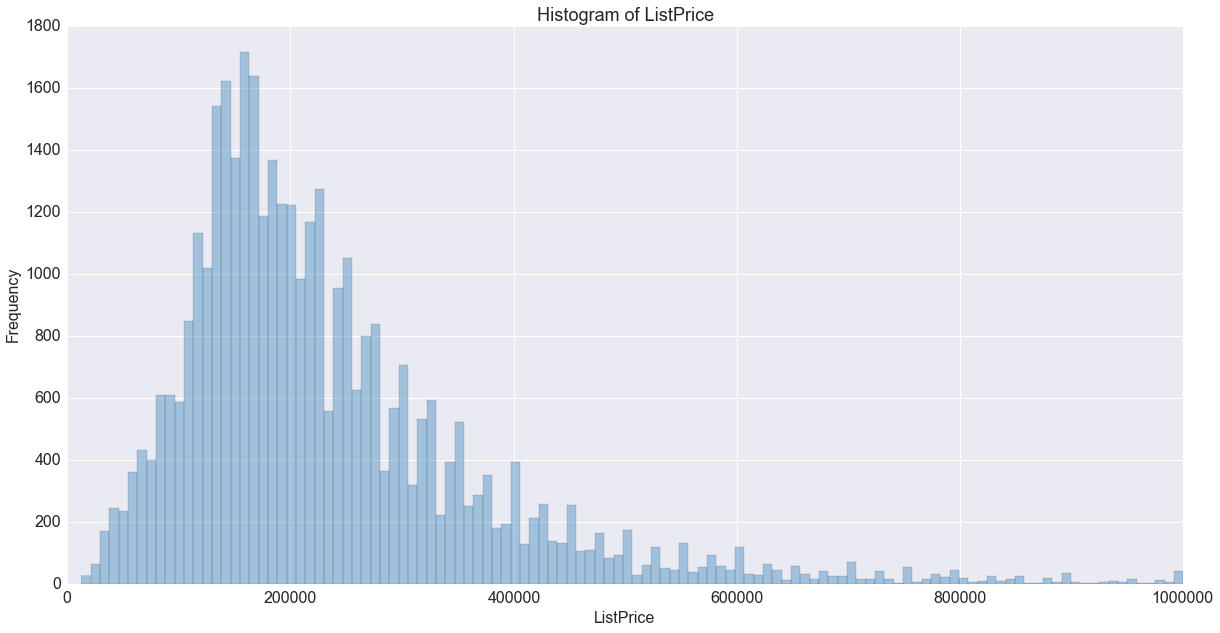

In [27]:
temp_df = df[(df['ListPrice'] >= 10000) & (df['ListPrice'] <= 1000000)]
plt.figure(figsize = (20, 10))
sns.distplot(temp_df['ListPrice'].dropna(), kde = False, rug = False, color =  '#3182bd')
plt.xlabel('ListPrice', fontsize = 16)
#plt.xscale('log')
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram of ListPrice', fontsize = 18)

**Note:** 
- Living Area Outliers: <font color=red>Need to remove datapoints where ListPrice is less than 10000 and ListPrice is greater than 1000000 </font> **Right tailed distribution**

In [28]:
df = df[(df['ListPrice'] >= 10000) & (df['ListPrice'] <= 1000000)]

In [29]:
print df.columns.values

['ListingId' 'LivingArea' 'NumBedrooms' 'NumBaths' 'Pool' 'ExteriorStories'
 'ListDate' 'ListPrice' 'GeoLat' 'GeoLon' 'PublicRemarks' 'CloseDate'
 'ClosePrice' 'ListingStatus' 'DwellingType']


In [30]:
# Get Status count
status = list(np.sort(df['ListingStatus'].unique()))
for s in status:
    temp_df = df[df['ListingStatus'] == s]
    print s + ' count: ' + str(temp_df.shape[0])

Active count: 59
Cancelled count: 136
Closed count: 37106
Expired count: 44
Pending count: 80
Temp Off Market count: 4


**Observations**  
- Why listings with "Active" or "Cancelled" or "Expired" or "Pending" or "Temp Off Market" status has closeDate?

**Hypothesis to ponder**
- Does the number of days between "ListDate" and "CloseDate" explain "ClosePrice"?
- How is the Phoenix region economy doing during when the property was listed?

In [31]:
df[df['ListingStatus'] == 'Temp Off Market'].head(3)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,PublicRemarks,CloseDate,ClosePrice,ListingStatus,DwellingType
18800,5105361,2128,5,2.5,Community,2,2014-04-21,155000,33.422981,-112.298791,SHORT SALE. Bank has agreed to accept short s...,2015-02-28,133100,Temp Off Market,Single Family - Detached
30738,5123620,3460,5,3.5,Private,2,2014-05-28,359900,33.308479,-111.799804,BACK ON MARKET! Your dream home awaits in this...,2014-12-30,379900,Temp Off Market,Single Family - Detached
43572,5143967,865,2,1.0,Community,1,2014-07-14,45000,33.551502,-112.189161,**This is an incredible short sale opportunity...,2014-11-17,42500,Temp Off Market,Townhouse


In [32]:
# Create a new feature: NumDays = CloseDate - ListDate
df['NumDays'] = df['CloseDate'] - df['ListDate']
df['NumDays'] = df['NumDays'].map(lambda d: d/np.timedelta64(1, 'D'))
df['NumDays'].head(3)

1    115
2    136
3     88
Name: NumDays, dtype: float64

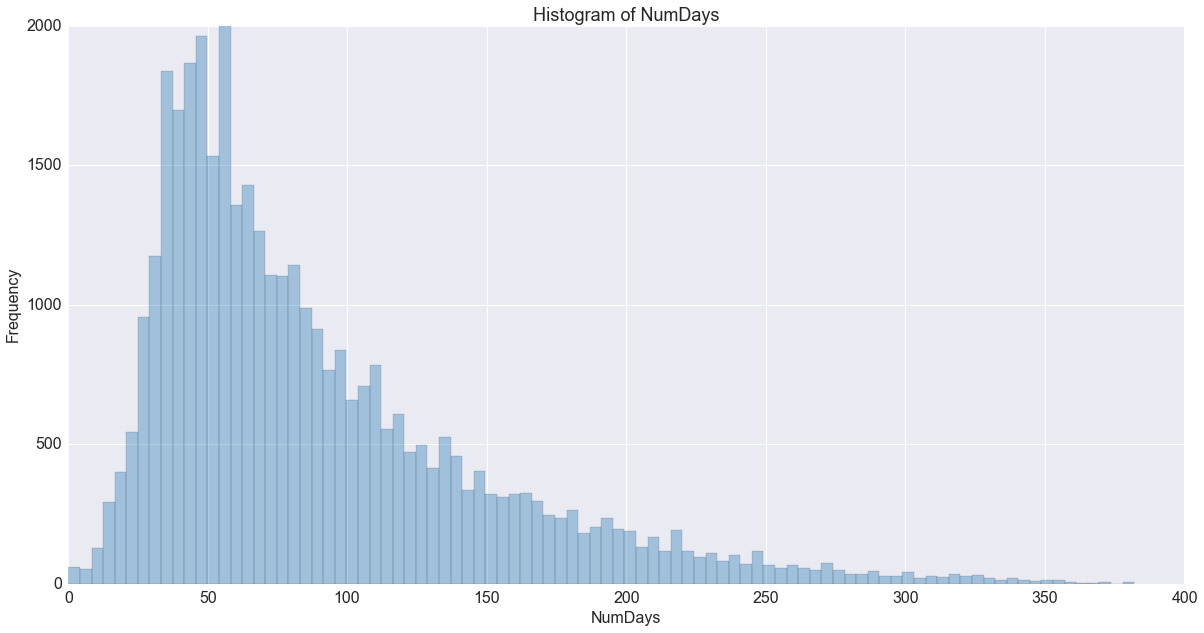

In [34]:
plt.figure(figsize = (20, 10))
sns.distplot(df['NumDays'].dropna(), kde = False, rug = False, color =  '#3182bd')
plt.xlabel('NumDays', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title('Histogram of NumDays', fontsize = 18)

# Right tailed distribution

**Transform Categorical variables to Binary variables: Dummy Variables**

In [35]:
# Create dummy variables
pool_dummies = pd.get_dummies(df['Pool'])
status_dummies = pd.get_dummies(df['ListingStatus'])
dwelling_dummies = pd.get_dummies(df['DwellingType'])

# Rename columns
pool_dummies = pool_dummies.rename(columns = lambda x: 'Pool_' + x.replace(' ', ''))
status_dummies = status_dummies.rename(columns = lambda x: 'Status_' + x.replace(' ', ''))
dwelling_dummies = dwelling_dummies.rename(columns = lambda x: 'Dweling_' + x.replace(' ', ''))

# Add new dummy variables back to the original dataset
df = pd.concat([df, pool_dummies, status_dummies, dwelling_dummies], axis=1)

In [36]:
df.head(3)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,...,Status_Pending,Status_TempOffMarket,Dweling_ApartmentStyle/Flat,Dweling_Gemini/TwinHome,Dweling_LoftStyle,Dweling_Mfg/MobileHousing,Dweling_Modular/Pre-Fab,Dweling_PatioHome,Dweling_SingleFamily-Detached,Dweling_Townhouse
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,...,0,0,0,0,0,0,0,0,1,0
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,...,0,0,0,0,0,0,0,0,1,0
3,5077487,2440,4,2.5,None,2,2014-03-01,229900,33.647270,-112.251490,...,0,0,0,0,0,0,0,0,1,0


### Modeling

In [37]:
df.columns.values

array(['ListingId', 'LivingArea', 'NumBedrooms', 'NumBaths', 'Pool',
       'ExteriorStories', 'ListDate', 'ListPrice', 'GeoLat', 'GeoLon',
       'PublicRemarks', 'CloseDate', 'ClosePrice', 'ListingStatus',
       'DwellingType', 'NumDays', 'Pool_BothPrivate&Community',
       'Pool_Community', 'Pool_None', 'Pool_Private', 'Status_Active',
       'Status_Cancelled', 'Status_Closed', 'Status_Expired',
       'Status_Pending', 'Status_TempOffMarket',
       'Dweling_ApartmentStyle/Flat', 'Dweling_Gemini/TwinHome',
       'Dweling_LoftStyle', 'Dweling_Mfg/MobileHousing',
       'Dweling_Modular/Pre-Fab', 'Dweling_PatioHome',
       'Dweling_SingleFamily-Detached', 'Dweling_Townhouse'], dtype=object)

In [38]:
model_df = df.copy()
model_df.reset_index()
model_df.head(3)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,...,Status_Pending,Status_TempOffMarket,Dweling_ApartmentStyle/Flat,Dweling_Gemini/TwinHome,Dweling_LoftStyle,Dweling_Mfg/MobileHousing,Dweling_Modular/Pre-Fab,Dweling_PatioHome,Dweling_SingleFamily-Detached,Dweling_Townhouse
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,...,0,0,0,0,0,0,0,0,1,0
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,...,0,0,0,0,0,0,0,0,1,0
3,5077487,2440,4,2.5,None,2,2014-03-01,229900,33.647270,-112.251490,...,0,0,0,0,0,0,0,0,1,0


In [39]:
# Delete categorical columns (string columns), dummy column (to avoid multicollinearity), date columns, lat-long data 
cols_to_del = ['ListingId', 'Pool', 'ListDate', 'GeoLat', 'GeoLon', 'PublicRemarks','CloseDate', 
               'ListingStatus', 'DwellingType', 'Pool_None', 'Status_TempOffMarket', 'Dweling_LoftStyle']

for col in cols_to_del:
    del model_df[col]
    
model_df.head(3)

,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,ClosePrice,NumDays,Pool_BothPrivate&Community,Pool_Community,Pool_Private,...,Status_Closed,Status_Expired,Status_Pending,Dweling_ApartmentStyle/Flat,Dweling_Gemini/TwinHome,Dweling_Mfg/MobileHousing,Dweling_Modular/Pre-Fab,Dweling_PatioHome,Dweling_SingleFamily-Detached,Dweling_Townhouse
1,2230,4,2.0,1,475000,460000,115,0,0,1,...,1,0,0,0,0,0,0,0,1,0
2,1601,3,2.0,1,279900,279900,136,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,2440,4,2.5,2,229900,228000,88,0,0,0,...,1,0,0,0,0,0,0,0,1,0


### Linear Regression with "ListPrice" covariate

In [40]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

In [51]:
# Remove Y
x_features = list(model_df.columns.values)
x_features.remove('ClosePrice')

In [52]:
X = model_df[x_features].values
y = model_df['ClosePrice'].values
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [53]:
clf_with = LinearRegression()
clf_with.fit(X_train_with, y_train_with)

# Error Metric: Mean Squared Error or Residual Sum of Squares
mse = np.mean((clf_with.predict(X_test_with) - y_test_with)**2)
print 'Residual sum of squares: {}'.format(mse)

# Error Metric: Root Mean Squared Error 
rmse = np.sqrt(np.mean((clf_with.predict(X_test_with) - y_test_with)**2))
print 'Root Mean Squared Error: {}'.format(rmse)

# Error Metric: Explained variance score or
ev = clf_with.score(X_test_with, y_test_with)
print 'Explained variance score: {}'.format(ev)

Residual sum of squares: 98653745.6145
Root Mean Squared Error: 9932.45919269
Explained variance score: 0.994663069103


In [54]:
# The coefficients
print 'Coefficients: \n', clf_with.coef_

Coefficients: 
[  1.09289865e+00   4.14631846e+02   9.55128374e+00  -8.76362133e+01
   9.56709078e-01  -1.36905019e+01   7.62404406e+02   1.23792946e+01
   1.31185505e+03  -2.14304238e+04  -2.80156564e+03   8.11456845e+02
  -5.48397081e+03   3.21175663e+03  -6.26356486e+03  -7.50802043e+03
  -9.25079451e+03  -6.99454691e+03  -7.37037134e+03  -4.98480780e+03
  -6.62946046e+03]


In [75]:
import statsmodels.formula.api as sm

# Without intercept
result = sm.OLS(y_train_with, X_train_with).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.907e+05
Date:                Sat, 02 Jan 2016   Prob (F-statistic):               0.00
Time:                        16:52:25   Log-Likelihood:            -2.7817e+05
No. Observations:               26200   AIC:                         5.564e+05
Df Residuals:                   26179   BIC:                         5.566e+05
Df Model:                          21                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.0874      0.165      6.577      0.000         0.763     1.411
x2           418.0068    109.511      3.817      0.000       203.360   632.654
x3             9.5567      9.098      1.050      0.294        -8.275    27.388
x4           -78.3163     84.251     -0.930      0.353      -243.452    86.820
x5             0.9567      0.001   1396.506      0.000         0.955     0.958
x6           -13.6580      1.049    -13.019      0.000       -15.714   -11.602
x7           765.2430    348.052      2.199      0.028        83.042  1447.444
x8            18.2833    180.891      0.101      0.919      -336.272   372.839
x9          1313.5735    164.424      7.989      0.000       991.293  1635.854
x10        -1.645e+04   2696.410     -6.102      0.000     -2.17e+04 -1.12e+04
x11         2190.8803   2392.772      0.916      0.360     -2499.084  6880.844
x12         5793.7425   2205.194      2.627      0.009      1471.442  1.01e+04
x13         -502.8095   2766.650     -0.182      0.856     -5925.594  4919.975
x14         8190.3009   2586.781      3.166      0.002      3120.068  1.33e+04
x15        -5053.5992   2196.913     -2.300      0.021     -9359.669  -747.529
x16        -6283.7911   2316.901     -2.712      0.007     -1.08e+04 -1742.538
x17        -8025.7179   2243.300     -3.578      0.000     -1.24e+04 -3628.727
x18        -5769.6976   3604.835     -1.601      0.109     -1.28e+04  1295.976
x19        -6148.8969   2258.174     -2.723      0.006     -1.06e+04 -1722.753
x20        -3762.5848   2200.778     -1.710      0.087     -8076.230   551.060
x21        -5411.4315   2200.027     -2.460      0.014     -9723.604 -1099.259
==============================================================================
Omnibus:                    28063.372   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         43845501.658
Skew:                          -4.372   Prob(JB):                         0.00
Kurtosis:                     203.218   Cond. No.                     3.43e+07
==============================================================================

Warnings:
[1] The condition number is large, 3.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
pVals = result.pvalues
pVals[4]

0.0

**p-value** for the coefficient of **ListPrice** = 0.0 i.e. $P(T > |t|) < \alpha = 0.05$

### Linear Regression without "ListPrice" covariate

In [55]:
# Remove Y and ListPrice
x_features = list(model_df.columns.values)
x_features.remove('ClosePrice')
x_features.remove('ListPrice')

In [56]:
X = model_df[x_features].values
y = model_df['ClosePrice'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state= 42)

In [57]:
clf = LinearRegression()
clf.fit(X_train, y_train)

# Error Metric: Mean Squared Error or Residual Sum of Squares
mse = np.mean((clf.predict(X_test) - y_test)**2)
print 'Residual sum of squares: {}'.format(mse)

# Error Metric: Root Mean Squared Error 
rmse = np.sqrt(np.mean((clf.predict(X_test) - y_test)**2))
print 'Root Mean Squared Error: {}'.format(rmse)

# Error Metric: Explained variance score or
ev = clf.score(X_test, y_test)
print 'Explained variance score: {}'.format(ev)

Residual sum of squares: 7324505212.41
Root Mean Squared Error: 85583.3232144
Explained variance score: 0.603761844691


In [58]:
# The coefficients
print 'Coefficients: \n', clf.coef_

Coefficients: 
[  1.53112371e+02  -3.51654051e+04   8.75750341e+01  -1.02438581e+04
   1.36794333e+00   6.71428418e+04   7.67105205e+03   4.94122752e+04
  -2.28340394e+04   6.48851163e+03   3.50123058e+04   1.80445739e+03
   3.66566116e+04  -1.74103182e+05  -2.41677483e+05  -2.44157245e+05
  -2.36526421e+05  -1.63228341e+05  -1.77761594e+05  -1.83063246e+05]


In [60]:
# Without intercept
result = sm.OLS(y_train, X_train).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                 1.110e+04
Date:                Sat, 02 Jan 2016   Prob (F-statistic):               0.00
Time:                        16:33:41   Log-Likelihood:            -3.3482e+05
No. Observations:               26200   AIC:                         6.697e+05
Df Residuals:                   26180   BIC:                         6.698e+05
Df Model:                          20                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           153.0340      1.082    141.480      0.000       150.914   155.154
x2         -3.508e+04    925.511    -37.906      0.000     -3.69e+04 -3.33e+04
x3            87.7889     79.044      1.111      0.267       -67.142   242.720
x4         -9963.5936    729.439    -13.659      0.000     -1.14e+04 -8533.853
x5             2.3751      9.115      0.261      0.794       -15.490    20.240
x6          6.727e+04   2995.671     22.456      0.000      6.14e+04  7.31e+04
x7          7856.9533   1570.943      5.001      0.000      4777.820  1.09e+04
x8          4.949e+04   1396.826     35.433      0.000      4.68e+04  5.22e+04
x9          1.301e+05   2.34e+04      5.556      0.000      8.42e+04  1.76e+05
x10         1.599e+05   2.08e+04      7.697      0.000      1.19e+05  2.01e+05
x11         1.881e+05   1.91e+04      9.833      0.000      1.51e+05  2.26e+05
x12         1.548e+05    2.4e+04      6.446      0.000      1.08e+05  2.02e+05
x13         1.896e+05   2.24e+04      8.447      0.000      1.46e+05  2.34e+05
x14         -1.37e+05   1.91e+04     -7.186      0.000     -1.74e+05 -9.97e+04
x15        -2.042e+05   2.01e+04    -10.163      0.000     -2.44e+05 -1.65e+05
x16        -2.067e+05   1.95e+04    -10.624      0.000     -2.45e+05 -1.69e+05
x17         -1.99e+05   3.13e+04     -6.359      0.000      -2.6e+05 -1.38e+05
x18        -1.258e+05   1.96e+04     -6.416      0.000     -1.64e+05 -8.74e+04
x19        -1.403e+05   1.91e+04     -7.345      0.000     -1.78e+05 -1.03e+05
x20        -1.458e+05   1.91e+04     -7.633      0.000     -1.83e+05 -1.08e+05
==============================================================================
Omnibus:                     7265.030   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35394.716
Skew:                           1.264   Prob(JB):                         0.00
Kurtosis:                       8.102   Cond. No.                     2.57e+05
==============================================================================

Warnings:
[1] The condition number is large, 2.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

## Feature Engineering - TFIDF

```python
import re
from nltk.corpus import stopwords

def remark_to_wordlist(remark):
    if type(remark) == str:
        # Remove numbers
        text = re.sub('[^a-z]', ' ', remark)
        # Convert words to lower case
        text = text.lower()
        # Split into separate words
        words = text.split()
        # Remove english stopwords
        filtered = [w for w in words if w not in stopwords.words('english')]
        sentence = ' '.join(filtered)
        return sentence
    else:
        return 'error'
        
df['remark'] = df['remark'].map(lambda remark: remark_to_wordlist(remark))
```

In [ ]:
# Ref: http://ankoorb.blogspot.com/2014/12/sentiment-analysis-on-rotten-tomatoes.html

import re
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
public_remarks = pd.DataFrame(df['PublicRemarks'])

> ## Testing TFIDF 

In [ ]:
a = ['Cream color glazed cabinetry.']
b = ['Travertine stone flooring.']
c = ['Gorgeous tiled showers.']
d = [np.nan]
strs = pd.DataFrame([a, b, c, d])
strs.columns = ['text']
print type(strs['text'][3])

# Fill NaN with a string
strs.fillna('error', inplace = True)
strs.head()

In [ ]:
# Tokenize text 
count_vector = CountVectorizer()
counts = count_vector.fit_transform(strs['text'])

print counts.shape
print len(count_vector.get_feature_names())
print count_vector.get_feature_names()

# Count Matrix to DataFrame
pd.DataFrame(counts.todense())

In [ ]:
# Term Frequency times Inverse Document Frequency (tf-idf)
# Use fit_transform() method to transform count-matrix to 'tf-idf' representation
x = pd.DataFrame(TfidfTransformer().fit_transform(counts).todense())
x.head(3)

In [ ]:
# Rename columns
x.columns = count_vector.get_feature_names()
x.head()

In [ ]:
public_remarks.fillna('error', inplace = True)

In [ ]:
import re
from nltk.corpus import stopwords

def remark_to_wordlist(remark):
    if type(remark) == str:
        # Remove numbers
        text = re.sub('[^a-z]', ' ', remark)
        # Convert words to lower case
        text = text.lower()
        # Split into separate words
        words = text.split()
        # Remove english stopwords
        filtered = [w for w in words if w not in stopwords.words('english')]
        sentence = ' '.join(filtered)
        return sentence
    else:
        return 'error'

In [ ]:
# Takes time to run!
public_remarks['PublicRemarks'] = public_remarks['PublicRemarks'].map(lambda remark: remark_to_wordlist(remark))

In [ ]:
# Tokenize text 
count_vector = CountVectorizer()
counts = count_vector.fit_transform(public_remarks['PublicRemarks'])

print counts.shape
print len(count_vector.get_feature_names())

In [ ]:
# Term Frequency times Inverse Document Frequency (tf-idf)
# Use fit_transform() method to transform count-matrix to 'tf-idf' representation
public_remarks_tfidf = pd.DataFrame(TfidfTransformer().fit_transform(counts).todense())
public_remarks_tfidf.head(3)

In [ ]:
# Rename columns
public_remarks_tfidf.columns = count_vector.get_feature_names()
public_remarks_tfidf.head(3)

In [ ]:
# Concatenate dataframe: Not enough storage space on my laptop
#df = pd.concat([df, public_remarks_tfidf], axis=1)
#print df.shape

### Part 2 Web Scraping and Simple n grams

scrape [N-gram](https://en.wikipedia.org/wiki/N-gram) wikipedia webpage and generate top 10 3-grams.  

Here is the output:

**Output:**
```python
Top: 1  3-gram (with frequency): ((u'an', u'n-gram', u'model'), 5)
Top: 2  3-gram (with frequency): ((u'n-gram', u'models', u'are'), 4)
Top: 3  3-gram (with frequency): ((u'natural', u'language', u'processing'), 4)
Top: 4  3-gram (with frequency): ((u'part', u'of', u'the'), 4)
Top: 5  3-gram (with frequency): ((u'of', u'a', u'possible'), 3)
Top: 6  3-gram (with frequency): ((u'for', u'sequences', u'of'), 3)
Top: 7  3-gram (with frequency): ((u'can', u'also', u'be'), 3)
Top: 8  3-gram (with frequency): ((u'be', u'used', u'for'), 3)
Top: 9  3-gram (with frequency): ((u'the', u'number', u'of'), 3)
Top: 10  3-gram (with frequency): ((u'computational', u'linguistics', u'and'), 3)
```

In [1]:
import urllib2
from bs4 import BeautifulSoup

# NLTK
import nltk
from nltk import RegexpTokenizer
from nltk import trigrams

In [2]:
url = 'https://en.wikipedia.org/wiki/N-gram'
html = urllib2.urlopen(url)
bsObj = BeautifulSoup(html)

#print bsObj.prettify().encode('utf-8')

/Applications/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [3]:
# Check <p> tags
p = bsObj.findAll('p')
print 'Number of <p> tags: {}'.format(len(p))
print '------------------------------------------------------------------'
print 'Text from first <p> tag: \n', p[0].get_text()
print '------------------------------------------------------------------'
print 'Text from last <p> tag: \n', p[len(p)-1].get_text()

Number of <p> tags: 39
------------------------------------------------------------------
Text from first <p> tag: 
In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sequence of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. When the items are words, n-grams may also be called shingles.[1]
------------------------------------------------------------------
Text from last <p> tag: 
Syntactic n-grams are intended to reflect syntactic structure more faithfully than linear n-grams, and have many of the same applications, especially as features in a Vector Space Model. Syntactic n-grams for certain tasks gives better results than the use of standard n-grams, for example, for authorship attribution.[15]


In [4]:
# Extract all the text from <p> tags
text = []
p_tags = bsObj.findAll('p')
for i in range(len(p_tags)):
    text.append(p_tags[i].get_text())

In [5]:
# Convert list to a string
string = ', '.join(text)
print string[:250]

In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sequence of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-


In [6]:
# Tokenize the string

#tokens = nltk.wordpunct_tokenize(string) # splits n-gram and removes numbers
#print tokens

# Use Regular Expression
tokenizer = RegexpTokenizer('[a-zA-Z0-9\-]+')
tokens = tokenizer.tokenize(string)
print 'First 5 tokens: ', tokens[:5]

# Lower case
tokens = [token.lower() for token in tokens]
print 'First 5 tokens (lower case): ', tokens[:5]

First 5 tokens:  [u'In', u'the', u'fields', u'of', u'computational']
First 5 tokens (lower case):  [u'in', u'the', u'fields', u'of', u'computational']


In [7]:
# Generate 3-grams
tri_grams = trigrams(tokens)

# Get frequency distribution of 3-grams
fdist = nltk.FreqDist(tri_grams)

# Get top 10 3-grams
top_tri_grams = fdist.most_common(10)

In [8]:
for i, j in enumerate(top_tri_grams):
    print 'Top: ' + str(i+1) + '  3-gram (with frequency): ' + str(j)

Top: 1  3-gram (with frequency): ((u'an', u'n-gram', u'model'), 5)
Top: 2  3-gram (with frequency): ((u'n-gram', u'models', u'are'), 4)
Top: 3  3-gram (with frequency): ((u'natural', u'language', u'processing'), 4)
Top: 4  3-gram (with frequency): ((u'part', u'of', u'the'), 4)
Top: 5  3-gram (with frequency): ((u'of', u'a', u'possible'), 3)
Top: 6  3-gram (with frequency): ((u'for', u'sequences', u'of'), 3)
Top: 7  3-gram (with frequency): ((u'can', u'also', u'be'), 3)
Top: 8  3-gram (with frequency): ((u'be', u'used', u'for'), 3)
Top: 9  3-gram (with frequency): ((u'the', u'number', u'of'), 3)
Top: 10  3-gram (with frequency): ((u'computational', u'linguistics', u'and'), 3)


### Part 3 Memoizer

Write a function that accepts a single argument function f , and an integer k , and returns a function that behaves the same as f except it caches the last k distinct accessed results of f. 


For instance, if memoize is the function we’re after, and let mem_f = memoize(f, 2) , then

● mem_f(arg1) → f(arg1) is computed and cached  
● mem_f(arg1) → f(arg1) is returned from cache  
● mem_f(arg2) → f(arg2) is computed and cached  
● mem_f(arg3) → f(arg3) is computed and cached, and f(arg1) is evicted  

In [9]:
def memoize(f, k):
    memo = []
    def helper(x):
        if f(x) not in memo:
            memo.append(f(x))
            if len(memo) > k:
                memo.pop(0)
        return memo
    return helper

def square(n):
    '''Calculate square of an int or float'''
    return n*n

mem_f = memoize(square, 2)

# Testing
print 'Output of mem_f(5): ', mem_f(5)
print 'Output of mem_f(15): ', mem_f(15)
print 'Output of mem_f(25): ', mem_f(25)
print 'Output of mem_f(15): ', mem_f(5)

Output of mem_f(5):  [25]
Output of mem_f(15):  [25, 225]
Output of mem_f(25):  [225, 625]
Output of mem_f(15):  [625, 25]


In [10]:
# Test when k = 2
test_2 = memoize(square, 2)

print test_2(0)
print test_2(1)
print test_2(90)
print test_2(1000)
print test_2(1000)

[0]
[0, 1]
[1, 8100]
[8100, 1000000]
[8100, 1000000]


In [11]:
# Test when k = 4
test_4 = memoize(square, 4)

print test_4(0)
print test_4(1)
print test_4(20)
print test_4(90)
print test_4(180)
print test_4(1000)

[0]
[0, 1]
[0, 1, 400]
[0, 1, 400, 8100]
[1, 400, 8100, 32400]
[400, 8100, 32400, 1000000]


In [12]:
# Test when k = 5
test_5 = memoize(square, 5)

print test_5(0)
print test_5(1)
print test_5(20)
print test_5(90)
print test_5(180)
print test_5(700)
print test_5(1000)

[0]
[0, 1]
[0, 1, 400]
[0, 1, 400, 8100]
[0, 1, 400, 8100, 32400]
[1, 400, 8100, 32400, 490000]
[400, 8100, 32400, 490000, 1000000]
